In [16]:
import numpy as np
import matplotlib.pyplot as plt

# American Option as an Integral Equation

## Solving for the optimal exercise boundary

### The Integral Equation

$$
S_f(t) - K = M_1(S_f(t), T-t, K) + \int_t^{T}Q_1(S_f(t), t, u, S_f(u)) du
$$

$$
Q_1(x,y,z,w) = x\delta e^{-\delta(z - y)} \Phi(d_1(x, z-y, w))
- rKe^{-r(z-y)}\Phi(d_2(x, z-y, w))
$$

$$
M_1(x,y,z) = xe^{-\delta y} \Phi (d_1(x,y,z)) - z e^{-ry}\Phi(d_2(x,y,z))
$$

$$
d_1(x, y, z) = \frac{\ln(x/z) + (r - \delta + \sigma^2/2)y}{\sigma\sqrt{y}}
$$

$$
d_2(x, y, z) = d_1(x,y,z)-\sigma\sqrt{y}
$$

$$
1_{(S=S_f)}(S) =
\begin{cases}
\frac{1}{2} & \textrm{if } S = S_f(t) \\ 
0 & \textrm{otherwise}
\end{cases}
$$

### Parameters

In [17]:
dividend = 0.02
strike_price = 100
volatility = 0.2
risk_free_rate = 0.05
time_to_maturity = 1

### Computation of necessary functions

In [18]:
from scipy.special import erf

# The CDF of the standard normal distribution
def phi(z):
    return (1.0 + erf(z / np.sqrt(2.0))) / 2.0

def d1(x, y, z):
    return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))

def d2(x, y, z):
    return d1(x, y, z) - volatility * np.sqrt(y)

def Q1(x, y, z, w):
    x = float(x)
    result = x * dividend * np.exp(-dividend * (z - y)) * phi(d1(x, z - y, w))
    result -= risk_free_rate * strike_price * np.exp(-risk_free_rate * (z - y)) * phi(d2(x, z - y, w))
    return result

def Q1_derivative_x(x, y, z, w):
    # Derivative of Q1 with respect to x using five-point stencil method
    h = 1e-5
    return (-Q1(x + 2*h, y, z, w) + 8*Q1(x + h, y, z, w) - 8*Q1(x - h, y, z, w) + Q1(x - 2*h, y, z, w)) / (12 * h)

def M1(x, y, z):
    x = float(x)
    result = x * np.exp(-dividend * y) * phi(d1(x, y, z)) - strike_price * np.exp(-risk_free_rate * y) * phi(d2(x, y, z))
    return result

def M1_derivative_x(x, y, z):
    # Derivative of M1 with respect to x using five-point stencil method
    h = 1e-5
    return (-M1(x + 2*h, y, z) + 8*M1(x + h, y, z) - 8*M1(x - h, y, z) + M1(x - 2*h, y, z)) / (12 * h)

### The Newton Raphson procedure

In [19]:
# Newton-Raphson method
def newton_raphson(f, f_prime, x0, tol=1e-8, max_iter=100):
    x = x0
    n_iter = 0
    for _ in range(max_iter):
        n_iter += 1
        fx = f(x)
        fpx = f_prime(x)
        if abs(fpx) < tol:
            raise ValueError("Derivative too small; no convergence.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return [x_new, n_iter]
        x = x_new
    print(f"Did not converge in {max_iter} iterations.")
    return [x, n_iter]

### Computing the solution

In [20]:
time_discretization = np.linspace(0, time_to_maturity, 252)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x, max_iter=10)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

Text(0.5, 0, 'Time (Maturity = 1)')

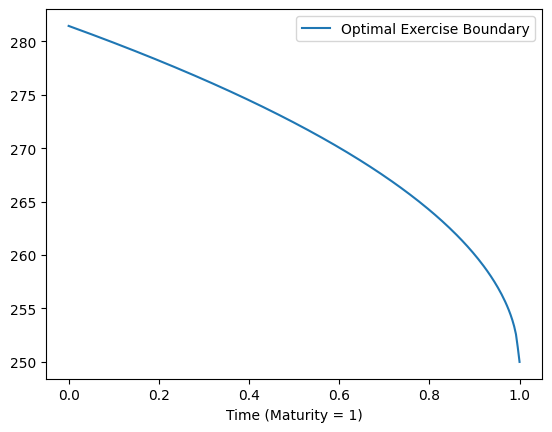

In [21]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Time (Maturity = 1)')

## Convergence analysis

Here, we plot the distribution of the number of steps needed for Newton Raphson procedures to converge.

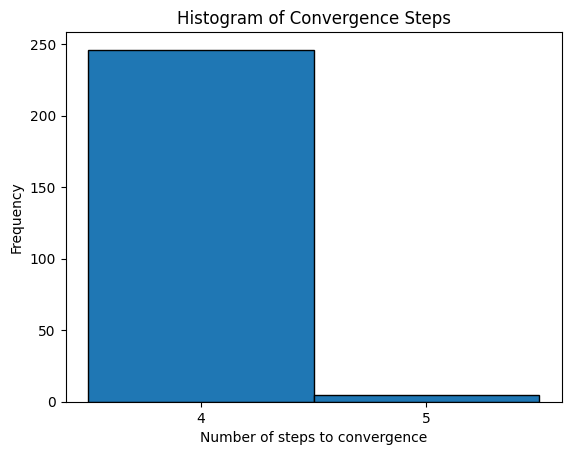

In [22]:
# Convert n_steps_to_convergence to a NumPy array
n_steps_to_convergence_array = np.array(n_steps_to_convergence)

# Assuming n_steps_to_convergence is a NumPy array of integer values:
min_val = n_steps_to_convergence_array.min()
max_val = n_steps_to_convergence_array.max()

# Create bins that cover each integer value. The -0.5 and +0.5 ensure that the bin is centered on the integer.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

plt.hist(n_steps_to_convergence_array, bins=bins, edgecolor='black')
plt.xticks(np.arange(min_val, max_val + 1))  # Set x-ticks to integer values
plt.xlabel('Number of steps to convergence')
plt.ylabel('Frequency')
plt.title('Histogram of Convergence Steps')
plt.show()

In qualitative terms, quadratic convergence means that each iteration typically doubles the number of correct digits. Since our tolerance is set at $10^{-8}$, about four iterations are required to achieve this level of precision, which strongly indicates that our convergence is indeed quadratic.

### What if the number of discretization decreases?

In [35]:
time_discretization = np.linspace(0, time_to_maturity, 32)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

Text(0.5, 0, 'Time (Maturity = 1)')

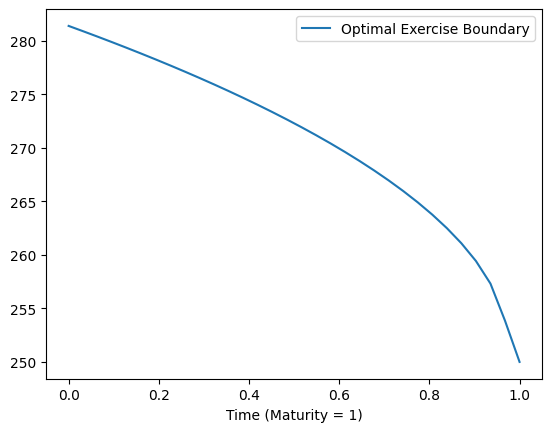

In [36]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Time (Maturity = 1)')

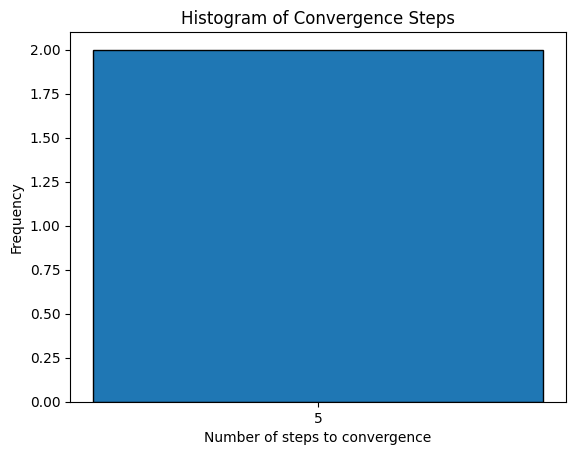

In [25]:
# Convert n_steps_to_convergence to a NumPy array
n_steps_to_convergence_array = np.array(n_steps_to_convergence)

# Assuming n_steps_to_convergence is a NumPy array of integer values:
min_val = n_steps_to_convergence_array.min()
max_val = n_steps_to_convergence_array.max()

# Create bins that cover each integer value. The -0.5 and +0.5 ensure that the bin is centered on the integer.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

plt.hist(n_steps_to_convergence_array, bins=bins, edgecolor='black')
plt.xticks(np.arange(min_val, max_val + 1))  # Set x-ticks to integer values
plt.xlabel('Number of steps to convergence')
plt.ylabel('Frequency')
plt.title('Histogram of Convergence Steps')
plt.show()

As we can see, even the number of discretization is 3, the Newton Raphson still converges. This means that even when the distance between the root and the initial guess is super far, we still have convergence (perhaps even quadratic). Therefore, it is likely that the function $f$ that we are finding the root has very nice property

### The plot of $f$

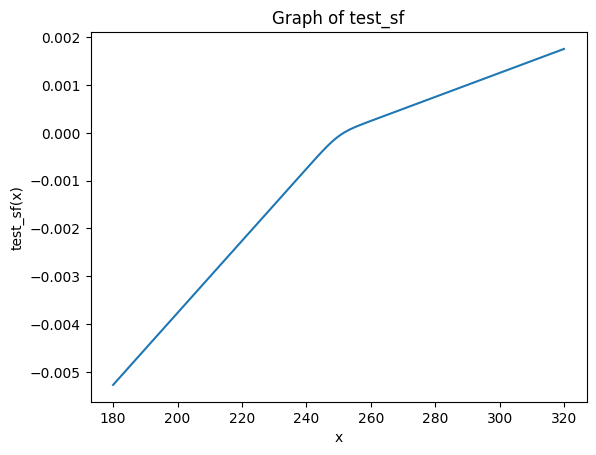

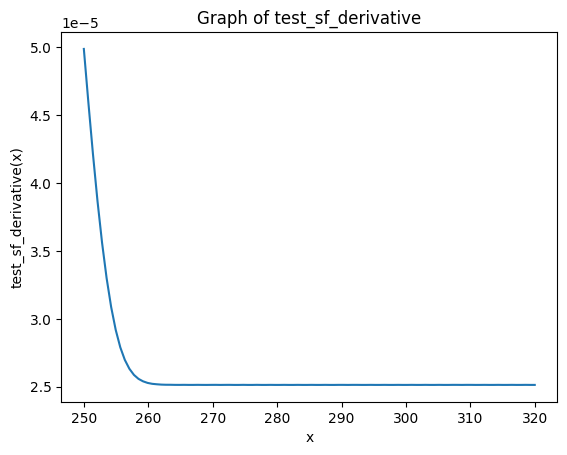

In [26]:
time_discretization = np.linspace(0, time_to_maturity, 200)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    if (i == 198):
        # Plot the graph of test_sf
        x_values = np.linspace(180, 320, 100)
        y_values = [test_sf(x) for x in x_values]
        plt.plot(x_values, y_values)
        plt.xlabel('x')
        plt.ylabel('test_sf(x)')
        plt.title('Graph of test_sf')
        plt.show()
        
        #Plot the graph of test_sf_derivative
        x_values = np.linspace(250, 320, 100)
        y_values = [test_sf_derivative(x) for x in x_values]
        plt.plot(x_values, y_values)
        plt.xlabel('x')
        plt.ylabel('test_sf_derivative(x)')
        plt.title('Graph of test_sf_derivative')
        plt.show()
        break
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

We can clearly see that our function $f$ is concave. From the theoretical result, we can prove that the convergence of Newton-Raphson method is unconditionally guaranteed.

### Verify the convergence rate

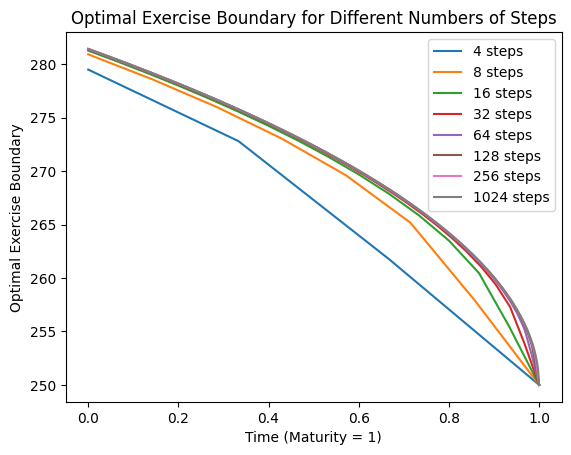

In [45]:
def test_by_n_discretizations(n_discretizations):
    time_discretization = np.linspace(0, time_to_maturity, n_discretizations)
    s_f_list = []
    for _ in range(len(time_discretization)):
        s_f_list.append([0, 0])  # Create a new list for each pair

    s_f_list[-1][1] = max(strike_price, risk_free_rate * strike_price / dividend)
    s_f_list[-1][0] = time_discretization[-1]

    n_steps = len(time_discretization) - 1
    n_steps_to_convergence = []
    for i in range(len(time_discretization) - 2, -1, -1):
        time_passed = i / n_steps
        guess_x = s_f_list[i + 1][1]
        def test_sf(x):
            test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1][1])
            test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
            for j in range(i + 1, len(time_discretization) - 1, 1):
                test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j][1])
                test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1][1])
            return test_result
        def test_sf_derivative(x):
            derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
            derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1][1])
            derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
            for j in range(i + 1, len(time_discretization) - 1):
                derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j][1])
                derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1][1])
            return derivative_result
        
        newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
        s_f_list[i][1] = newton_raphson_result[0]
        s_f_list[i][0] = time_discretization[i]
        n_steps_to_convergence.append(newton_raphson_result[1])
    return s_f_list

test_sizes = [4, 8, 16, 32, 64, 128, 256, 1024]
test_results = []
for (i, test_size) in enumerate(test_sizes):
    test_results.append(test_by_n_discretizations(test_size))
    plt.plot([x[0] for x in test_results[i]], [x[1] for x in test_results[i]], label=f'{test_size} steps')
plt.legend()
plt.xlabel('Time (Maturity = 1)')
plt.ylabel('Optimal Exercise Boundary')
plt.title('Optimal Exercise Boundary for Different Numbers of Steps')
plt.show()

In [74]:
def compute_mse(curve, ground_truth):
    """
    Compute the mean square error between a curve and the ground truth.
    
    Both curve and ground_truth are lists of [time, boundary] pairs.
    We interpolate the given curve to the time grid of ground_truth.
    """
    # Extract time and boundary arrays for the ground truth
    times_gt = np.array([pt[0] for pt in ground_truth])
    boundaries_gt = np.array([pt[1] for pt in ground_truth])
    
    # Extract time and boundary arrays for the curve we are comparing
    times_curve = np.array([pt[0] for pt in curve])
    boundaries_curve = np.array([pt[1] for pt in curve])
    
    # Interpolate the curve's boundary values at the ground truth times.
    boundaries_interp = np.interp(times_gt, times_curve, boundaries_curve)
    
    # Compute the mean squared error between the interpolated values and ground truth.
    mse = np.mean(np.abs(boundaries_interp - boundaries_gt)**2)
    # return the squared root of
    return mse

# Use the 1024 steps version as the ground truth.
ground_truth = test_results[-1]

# Prepare and print the results in a table.
print("Steps\tMSE")
for i, test_size in enumerate(test_sizes):
    # For the ground truth itself, the error is zero.
    if test_size == 1024:
        mse = 0.0
    else:
        mse = compute_mse(test_results[i], ground_truth)
    print(f"{test_size}\t{mse:.6f}")

Steps	MSE
4	24.744224
8	4.559477
16	0.967569
32	0.219174
64	0.050589
128	0.011318
256	0.002217
1024	0.000000


The experiment demonstrates second-order convergence: doubling the number of time steps generally reduces the mean square error by about a factor of four.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10444\317493448.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


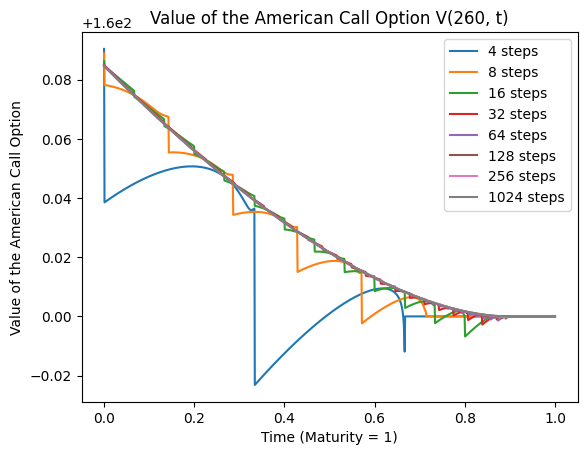

In [64]:
def compute_V(S, t, optimal_exercise_boundary):
    result = M1(S, time_to_maturity - t, strike_price)
    # Use trapezoidal rule to compute \int_t^T Q_1(S,t,u,S_f(u))\,du
    # Find the index of the first time point in the optimal exercise boundary that is greater than t
    idx = np.argmax([pt[0] >= t for pt in optimal_exercise_boundary])
    if (S > optimal_exercise_boundary[idx][1]):
        return S - strike_price
    # Compute the integral using the trapezoidal rule
    for i in range(idx, len(optimal_exercise_boundary) - 1):
        t_i, S_f_i = optimal_exercise_boundary[i]
        t_next, S_f_next = optimal_exercise_boundary[i + 1]
        result += 0.5 * (t_next - t_i) * (Q1(S, t, t_i, S_f_i) + Q1(S, t, t_next, S_f_next))
    return result

S = 260
time_discretization_for_V = np.linspace(0, time_to_maturity, 1024)
V_values = []
for i in range(len(test_results)):
    V_values.append([compute_V(S, t, test_results[i]) for t in time_discretization_for_V])
    plt.plot(time_discretization_for_V, V_values[i], label=f'{test_sizes[i]} steps')
plt.legend()
plt.xlabel('Time (Maturity = 1)')
plt.ylabel('Value of the American Call Option')
plt.title(f'Value of the American Call Option V({S}, t)')
plt.show()

In [76]:
ground_truth = np.array(V_values[-1])  # ground truth V curve (1024 steps)

print("Steps\tMSE")
for i, test_size in enumerate(test_sizes):
    if test_size == test_sizes[-1]:
        mse = 0.0
    else:
        curve = np.array(V_values[i])
        mse = np.mean(np.abs(curve - ground_truth)**2)
        mse = np.sqrt(mse)
    print(f"{test_size}\t{mse:.12f}")

Steps	MSE
4	0.021301007750
8	0.004654626629
16	0.001810032678
32	0.000603213657
64	0.000240197212
128	0.000092953685
256	0.000035858374
1024	0.000000000000
